# Imports

In [290]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest

# Constants

In [291]:
# Data generation
SAMPLE_TRAIN_SIZE = 100
SAMPLE_TEST_SIZE = 5
SAMPLE_OUTLIER_SIZE = 5

# Generalized Deduplication
DEVIATION_BITS = 2

# Load data

In [292]:
rng = np.random.RandomState(42)

# Generate train data
X_train = np.r_[(
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 60, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50)],
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)],
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)]
)]

# Generate test data
X_test = np.r_[(
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 60, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50)],
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)],
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)]
)]

# Generate outliers
X_outliers = np.r_[
    (np.c_[(rng.uniform(low=40, high=60, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=70, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))],
     np.c_[(rng.uniform(low=65, high=120, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=60, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))]
     )]
X_outliers = X_outliers.astype(int)

## Plot train, test and outliers in scatter plot

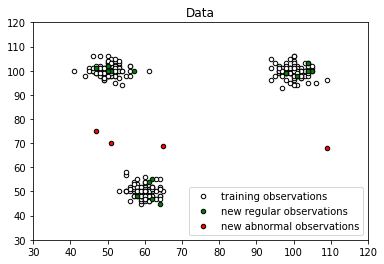

In [293]:
plt.title("Data")
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="lower right",
)
plt.show()

## Perform Generalized Deduplication

In [294]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")

X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

X_outliers_bases = vectorized_func(X_outliers, deviation_bits=DEVIATION_BITS, output="integer")


## Plot train, test and outliers after generalized deduplication in scatter plot

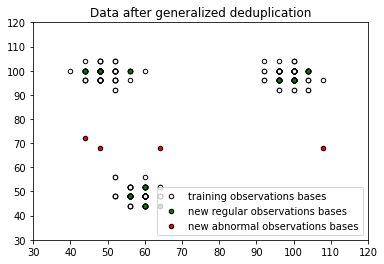

In [295]:
plt.title("Data after generalized deduplication")
b1 = plt.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations bases", "new regular observations bases", "new abnormal observations bases"],
    loc="lower right",
)
plt.show()

<AxesSubplot:ylabel='Density'>

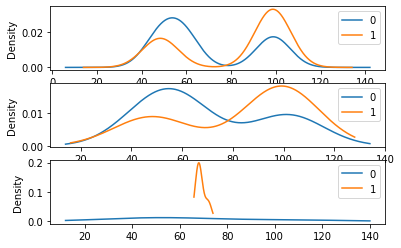

In [296]:
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
pd.DataFrame(X_outliers_bases).plot.density(ax=axes[2])

## Isolation Forest

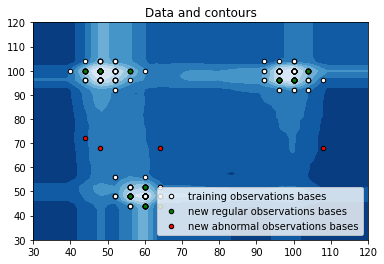

,0
0,-0.008563
1,0.038217
2,-0.044551
3,-0.197315
4,-0.008563
5,0.091029
6,0.091029
7,0.091029
8,-0.003687
9,-0.040178


In [305]:
clf = IsolationForest(random_state=rng)
clf.fit(X_train_bases)

y_pred_train = clf.predict(X_train_bases)
y_pred_test = clf.predict(X_test_bases)
y_pred_outliers = clf.predict(X_outliers_bases)

xx, yy = np.meshgrid(np.linspace(30, 120, 50), np.linspace(30, 120, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Data and contours")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations bases", "new regular observations bases", "new abnormal observations bases"],
    loc="lower right",
)
plt.show()

dec_function = clf.decision_function(X_test_bases)
pd.DataFrame(dec_function)

## Calculations

In [298]:
# Amount of base occurences
unique, counts = np.unique(X_train_bases, return_counts=True)
x_train_base_count = np.asarray((unique, counts)).T

In [299]:
def H(i):
    np.log(i) + 0.5772156649 # euler's constant

def c(n):
    2*H(n-1) - ((2*(n-1))/n)

In [300]:
def equation1(s, x, n):
    np.log2(s)*x*c(n)